# Abstract

To demonstrate the functionality of **state_at_date.foo** in a *tidy* manner, the following example provides a clear illustration using a single share and a few transactions.


# Set Up

In [ ]:
# install tidyverse package
install.packages("tidyverse")

In [ ]:
# install quantmod package
install.packages("quantmod")

In [ ]:
# load R packages
library(tidyverse)
library(quantmod)

In [7]:
# load state_at_date function
source(url("https://raw.githubusercontent.com/iNANOV/transaction-state-simulator/main/state_at_date.R"))

# Processing

In [8]:
# example of a order book transactions
order_book <- data.frame(
  yahoo_ticker = "AAPL",
  cash_initial = 2000,
  date = as.Date(c("2023-10-02", "2023-10-12","2023-10-18","2023-10-20")),
  amount = c(10,-2,-6, 7), #  > 0 : buy; < 0 : sell
  price = c(172.23, 181.54, 177.65, 173.11)
  )

 order_book

yahoo_ticker,cash_initial,date,amount,price
<chr>,<dbl>,<date>,<dbl>,<dbl>
AAPL,2000,2023-10-02,10,172.23
AAPL,2000,2023-10-12,-2,181.54
AAPL,2000,2023-10-18,-6,177.65
AAPL,2000,2023-10-20,7,173.11


In [10]:
# function for dowloading yahoo finance data in data frame format
yahoo_finance.foo <- function(ticker, From, To){
  # Download data and store it in variable `tab`
  tab <- getSymbols.yahoo(ticker, from = From, to = To, auto.assign = FALSE)

  # Rename the columns: remove the ticker prefix and make the first letter lowercase
  colnames(tab) <- tolower(sub(".*\\.", "", colnames(tab)))

  # Convert the index (dates) to a new 'date' column
  tab <- data.frame(symbol = ticker ,date = index(tab), coredata(tab))

  tab
}

# Get stock prices for a stock from Yahoo
stock_prices <- yahoo_finance.foo(unique(order_book$yahoo_ticker), From = min(order_book$date), To = max(order_book$date)+1) %>%
  # make upper case on the first letter to all columns except 'date'
  rename_with(
    .fn = ~ ifelse(.x == "date", .x, paste0(toupper(substr(.x, 1, 1)), tolower(substr(.x, 2, nchar(.x))))),
    .cols = everything()
  )

# download stock data from yahoo finance and join it with the order book
stock_prices_and_order_book <- left_join(stock_prices, dplyr::select(order_book, -"yahoo_ticker"))

glimpse(stock_prices_and_order_book)

Joining with `by = join_by(date)`


Rows: 15
Columns: 11
$ Symbol       <chr> "AAPL", "AAPL", "AAPL", "AAPL", "AAPL", "AAPL", "AAPL", "…
$ date         <date> 2023-10-02, 2023-10-03, 2023-10-04, 2023-10-05, 2023-10-…
$ Open         <dbl> 171.22, 172.26, 171.09, 173.79, 173.80, 176.81, 178.10, 1…
$ High         <dbl> 174.30, 173.63, 174.21, 175.45, 177.99, 179.05, 179.72, 1…
$ Low          <dbl> 170.93, 170.82, 170.97, 172.68, 173.18, 175.80, 177.95, 1…
$ Close        <dbl> 173.75, 172.40, 173.66, 174.91, 177.49, 178.99, 178.39, 1…
$ Volume       <dbl> 52164500, 49594600, 53020300, 48527900, 57224100, 4239080…
$ Adjusted     <dbl> 172.6754, 171.3338, 172.5860, 173.8283, 176.3923, 177.883…
$ cash_initial <dbl> 2000, NA, NA, NA, NA, NA, NA, NA, 2000, NA, NA, NA, 2000,…
$ amount       <dbl> 10, NA, NA, NA, NA, NA, NA, NA, -2, NA, NA, NA, -6, NA, 7
$ price        <dbl> 172.23, NA, NA, NA, NA, NA, NA, NA, 181.54, NA, NA, NA, 1…


In [11]:
# calculation of open positinions, cash, investment and performance state for each date
options(warn = -1)

cumulative_state <- stock_prices_and_order_book %>%
  # unite the columns needed for performance tracking
  unite("Cap", Close, amount, price, sep = "_", remove = FALSE) %>%
  mutate(
    state = accumulate(
      Cap,
      function(acc, curr) {
        # Combine previous accumulator and current value
        state_at_date.foo(acc, curr, initial_cash = stock_prices_and_order_book$cash_initial[1])
      },
      .init = list() # Initial empty list
    ) %>%
      tail(-1) # Remove the initial value
  ) %>%
  dplyr::select(-Cap) %>%
  unnest_wider(state)

# remove the 'open_positions' column which contains list with the open positons for each date
dplyr::select(cumulative_state, -open_positions) %>%
  glimpse()

Rows: 15
Columns: 14
$ Symbol       <chr> "AAPL", "AAPL", "AAPL", "AAPL", "AAPL", "AAPL", "AAPL", "…
$ date         <date> 2023-10-02, 2023-10-03, 2023-10-04, 2023-10-05, 2023-10-…
$ Open         <dbl> 171.22, 172.26, 171.09, 173.79, 173.80, 176.81, 178.10, 1…
$ High         <dbl> 174.30, 173.63, 174.21, 175.45, 177.99, 179.05, 179.72, 1…
$ Low          <dbl> 170.93, 170.82, 170.97, 172.68, 173.18, 175.80, 177.95, 1…
$ Close        <dbl> 173.75, 172.40, 173.66, 174.91, 177.49, 178.99, 178.39, 1…
$ Volume       <dbl> 52164500, 49594600, 53020300, 48527900, 57224100, 4239080…
$ Adjusted     <dbl> 172.6754, 171.3338, 172.5860, 173.8283, 176.3923, 177.883…
$ cash_initial <dbl> 2000, NA, NA, NA, NA, NA, NA, NA, 2000, NA, NA, NA, 2000,…
$ amount       <dbl> 10, NA, NA, NA, NA, NA, NA, NA, -2, NA, NA, NA, -6, NA, 7
$ price        <dbl> 172.23, NA, NA, NA, NA, NA, NA, NA, 181.54, NA, NA, NA, 1…
$ investment   <dbl> 1722.30, 1722.30, 1722.30, 1722.30, 1722.30, 1722.30, 172…
$ cash         <dbl>

In [12]:
# show the 'open_positions' column which contains list with the open positons for each date
dplyr::select(cumulative_state, date, open_positions) %>%
  unnest(open_positions) %>%
  group_by(date, price) %>%
  summarise(CLose = mean(Close), Price = mean(price), n = n()) %>%
  glimpse()

`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


Rows: 16
Columns: 5
Groups: date [15]
$ date  <date> 2023-10-02, 2023-10-03, 2023-10-04, 2023-10-05, 2023-10-06, 202…
$ price <dbl> 172.23, 172.23, 172.23, 172.23, 172.23, 172.23, 172.23, 172.23, …
$ CLose <dbl> 173.75, 172.40, 173.66, 174.91, 177.49, 178.99, 178.39, 179.80, …
$ Price <dbl> 172.23, 172.23, 172.23, 172.23, 172.23, 172.23, 172.23, 172.23, …
$ n     <int> 10, 10, 10, 10, 10, 10, 10, 10, 8, 8, 8, 8, 2, 2, 2, 7


# Quering

cash : initial cash + gains or loses of closed positions - investment;
 investment : invested capital in open positions;
 performance: performance from open positions


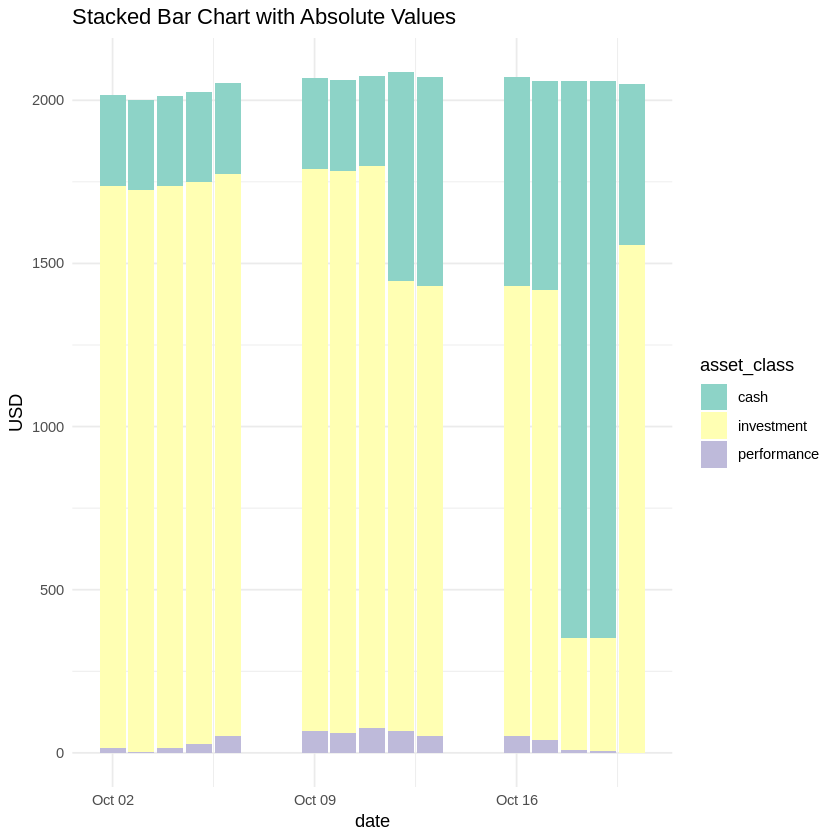

In [13]:
# Summarized asset classes distribution over time

suppressMessages({
  cumulative_state %>%
    dplyr::select(- open_positions) %>%
    pivot_longer(
      cols = c("investment", "cash", "performance"), # Select columns to pivot
      names_to = "asset_class",        # New column for key names
      values_to = "usd"          # New column for values
    ) %>%
    group_by(date, asset_class) %>%
    summarise(USD = sum(usd)) %>%
    ggplot(aes(x = date, y = USD, fill = asset_class)) +
    geom_bar(stat = "identity") +  # Use raw values (absolute)
    labs(title = "Stacked Bar Chart with Absolute Values") +
  scale_fill_brewer(palette = "Set3") +  # Optional: nice color palette
  theme_minimal()
})

cat("cash : initial cash + gains or loses of closed positions - investment;\n investment : invested capital in open positions;\n performance: performance from open positions\n")

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


Overall Performance: investment + cash + performance

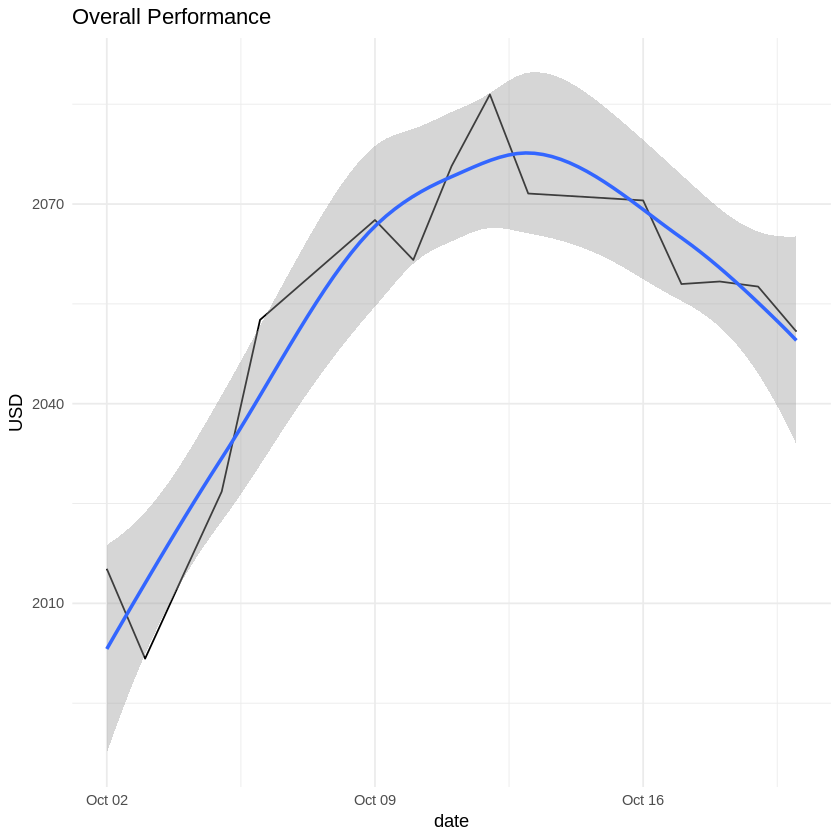

In [14]:
# Overall Performance in USD
cumulative_state %>%
  dplyr::select(- open_positions)  %>%
  mutate(USD = investment + cash + performance) %>%
  ggplot(aes(x = date, y = USD)) +
  geom_line() +
  geom_smooth()+
  labs(title = "Overall Performance") +
  theme_minimal()

cat("Overall Performance: investment + cash + performance")

pf : Portfolio based on the order book
 share: AAPL 

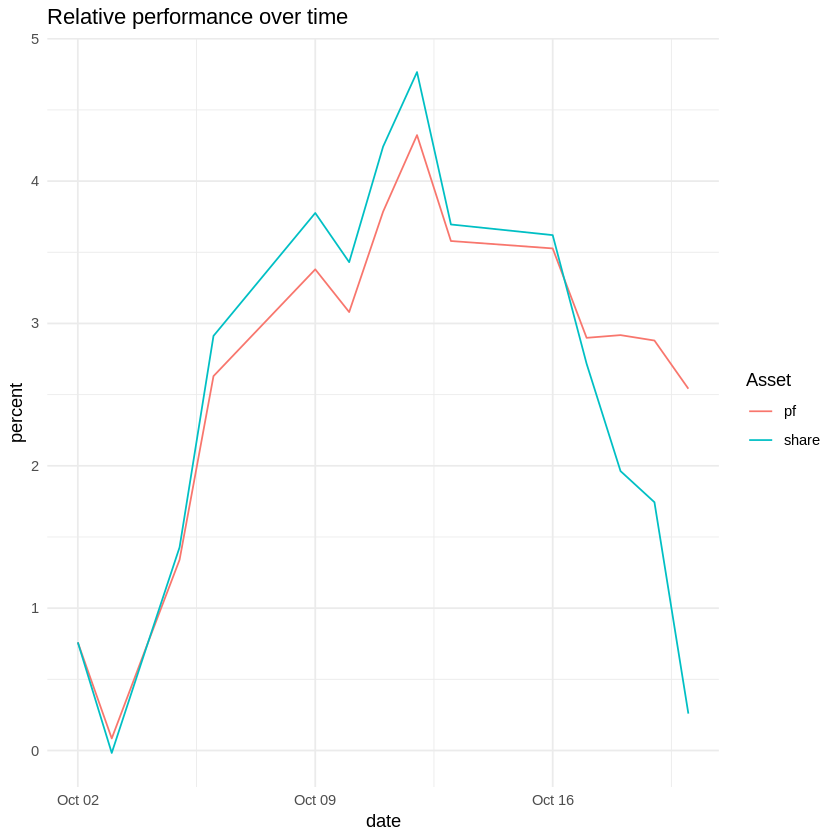

In [15]:
# Relative performance of the portfolio and share in percent
cumulative_state %>%
  dplyr::select(date, Adjusted, investment, cash, performance)  %>%
  # calculating Port folio and share performance
  mutate(pf = 100*(((investment + cash + performance) / cumulative_state$cash_initial[1])-1),
         share = 100*(Adjusted-first(Adjusted))/first(Adjusted)) %>%
 # level adjustment
  mutate(share = share + first(pf)) %>%
  pivot_longer(
    cols = c("pf", "share"),
    names_to = "Asset",
    values_to = "percent"
  ) %>%
  ggplot(aes(x = date, y = percent, col = Asset)) +
  geom_line() +
  labs(title = "Relative performance over time") +
  theme_minimal()

cat("pf : Portfolio based on the order book\n share: AAPL ")